<a href="https://colab.research.google.com/github/antonysamuel/Article-Datasets/blob/main/DenoisingAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

In [ ]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/content/',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root='/content/',train=False,download=True,transform=transform)

num_workers = 0
batch_size = 24

train_loader = torch.utils.data.DataLoader(train_data,batch_size,num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size,num_workers)

In [ ]:
import matplotlib.pyplot as plt

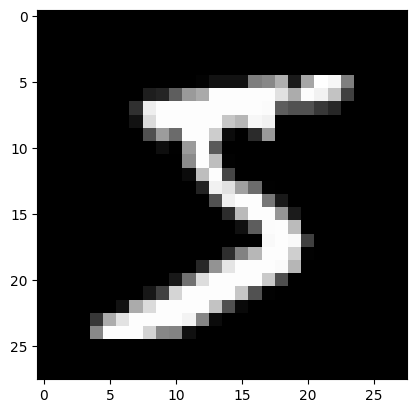

In [ ]:
dataiter = iter(train_loader)
img,label = next(dataiter)
plt.imshow(img[0].permute(1,2,0),cmap='gray')

In [ ]:
class ConvDenoiser(nn.Module):
  def __init__(self):
    super(ConvDenoiser,self).__init__()
    self.conv1 = nn.Conv2d(1,32,3,padding=1)
    self.conv2 = nn.Conv2d(32,16,3,padding=1)
    self.conv3 = nn.Conv2d(16,8,3,padding=1)
    self.pool = nn.MaxPool2d(2,2)

    self.t_conv1 = nn.ConvTranspose2d(8,8,3,stride=2)
    self.t_conv2 = nn.ConvTranspose2d(8,16,2,stride=2)
    self.t_conv3 = nn.ConvTranspose2d(16,32,2,stride=2)
    self.conv_out = nn.Conv2d(32,1,3,padding=1)
  
  def forward(self,x):
    #encode
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    #decode
    x = F.relu(self.t_conv1(x))
    x = F.relu(self.t_conv2(x))
    x = F.relu(self.t_conv3(x))
    x = F.sigmoid(self.conv_out(x))
    return x

model = ConvDenoiser()
print(model)



ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=.001)

In [ ]:
n_epochs = 15

noise_factor = 0.5

for e in range(1,n_epochs+1):
  train_loss = 0.0

  for data in train_loader:
    images,_ = data

    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    noisy_imgs = np.clip(noisy_imgs,0,1)

    optimizer.zero_grad()
    out = model(noisy_imgs)
    loss = criterion(out,images)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*images.size(0)
  train_loss = train_loss/len(train_loader)
  print(f'Epoch {e} \t Training Loss {train_loss}')




Epoch 1 	 Training Loss 0.572372899889946
Epoch 2 	 Training Loss 0.5636672262847423
Epoch 3 	 Training Loss 0.5562567653775216
Epoch 4 	 Training Loss 0.5502404038310051
Epoch 5 	 Training Loss 0.543581006795168
Epoch 6 	 Training Loss 0.5388025568783283
Epoch 7 	 Training Loss 0.5337791016697884
Epoch 8 	 Training Loss 0.5277245276749134
Epoch 9 	 Training Loss 0.5233557978093624
Epoch 10 	 Training Loss 0.5203481333076954


KeyboardInterrupt: ignored

In [ ]:
# with torch.no_grad():
#   out = model(img[0])
#   print(out.shape,img[0].shape)

torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


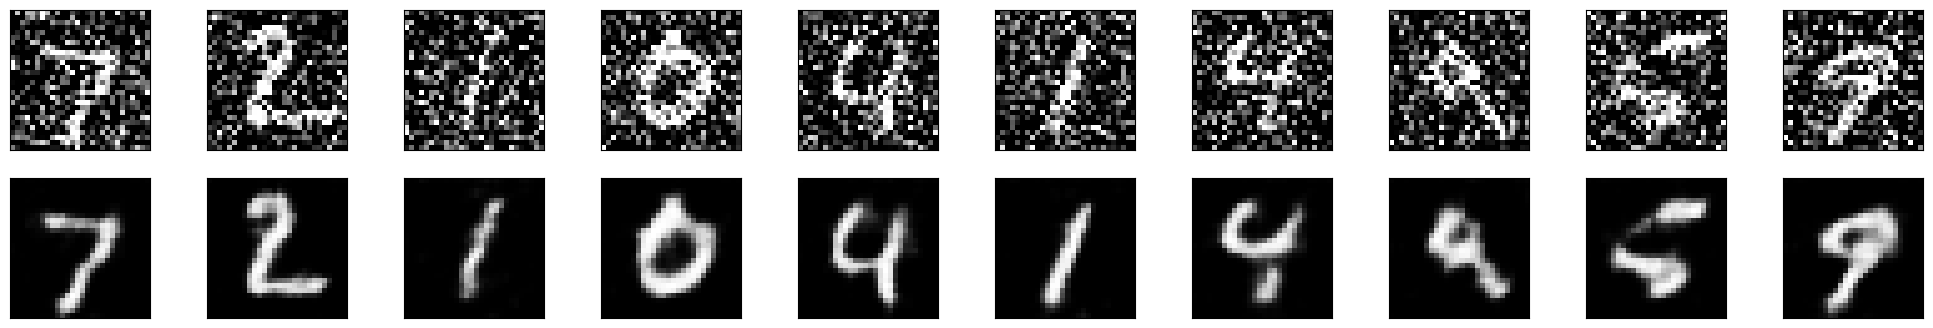

In [ ]:
dataiter = iter(test_loader)
imgs,_ = next(dataiter)

noisy_imgs = imgs + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs,0,1)

output = model(noisy_imgs)
output = output.view(batch_size,1,28,28)
output = output.detach().numpy()

fig,axes = plt.subplots(nrows = 2 , ncols = 10, sharex = True, sharey = True,figsize = (25,4))
for noisy_imgs, row in zip([noisy_imgs,output],axes):
  for img,ax in zip(noisy_imgs,row):
    ax.imshow(np.squeeze(img),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [ ]:
torch.save(model.state_dict(),'/content/denoisingMNIST_AE.pth')

In [ ]:
model_tst = ConvDenoiser()
model_tst.load_state_dict(torch.load('/content/denoisingMNIST_AE.pth'))

<All keys matched successfully>